In [21]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import modules.evaluate as evaluate
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import kendalltau
import modules.random_graph as random_graph
import math
import random
import matplotlib.ticker as ticker

soleGraphs= ["ba1", "ba2", "ba3", "er1", "er2", "er3"]


realGraphs= ["contious_usa", "contious_china", "contious_EU", "contious_Africa", "mobility_german", "mobility_us", "global_air"]

realGraphs3= ["us_air100", "us_air200", "us_air300", "us_air400", "spain_bus", "spain_car", "spain_plane", "spain_train"]

modelLoads= ["AA", "AB", "BA", "BB", "infer2018", "CosSim"]
weightModels= ["degree", "gravity", "identical"]
randomGraphs= ["ER", "BA", "WS", "RGG"]
seeds= [10, 11, 12, 13, 14]
strains= [1, 2, 3, 4]
denses= [0, -1, -2, -3, -4]
nodes= [50, 100, 200, 400]
intenses= [0, 1, 2, -1]

identicalfs= [2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1]# except 1e-2

commands1=set()
linuxThread= 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def continious_to_sparcity(my_array, top= 400):
    # Flatten the array to a 1D array
    flat_array = my_array.flatten()

    # Sort the flattened array in descending order
    sorted_indices = np.argsort(flat_array)[::-1]

    # Set the top 400 elements to 1 and the rest to 0
    flat_array[sorted_indices[:top]] = 1
    flat_array[sorted_indices[top:]] = 0

    # Reshape the modified 1D array back to the original shape
    result_array = flat_array.reshape(my_array.shape)
    return result_array

def continious_to_sparcity_cols(my_matrix, topRow= 8):

    result_matrix = np.zeros_like(my_matrix)
    indices = np.argsort(my_matrix, axis=1)[:, -topRow:]  # Get indices of top 8 elements in each row
    row_indices = np.arange(my_matrix.shape[0])[:, None]  # Row indices to broadcast
    result_matrix[row_indices, indices] = 1
    
    return result_matrix

def analyse_signal(signal):
    maxIndex = np.argmax(signal, axis= 2)
    signalCombine= signal.reshape(signal.shape[0], signal.shape[1]*signal.shape[2])
    meanV= maxIndex.mean()
    varV= np.var(maxIndex)
    simMatrix= cosine_similarity(signalCombine)
    simMatrixSumAVg= simMatrix.sum()/signal.shape[0]/signal.shape[0]
    return meanV, varV, simMatrixSumAVg

def scatter_points(x, y, xLabel="x", yLabel="y"):
    plt.scatter(x, y)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    pearson_corr = np.corrcoef(x, y)[0, 1]
    spearman_corr = np.corrcoef(np.argsort(x), np.argsort(y))[0, 1]
    kendall_corr, _ = kendalltau(x, y)
    print(f"Pearson correlation: {pearson_corr:.2f}, spearma correlation: {spearman_corr:.2f},  kendall correlation: {kendall_corr:.2f}")

1.9496503525837505e-05
1.7227224574739223e-05


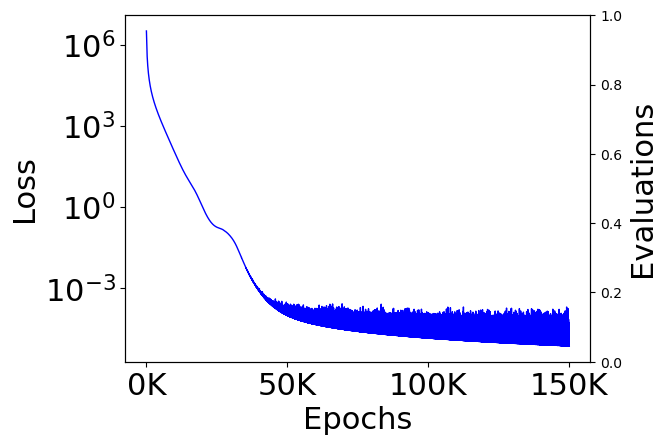

In [3]:

identicalf= 0.01

node= 100

strain= 4

# Define a custom formatter function
def custom_formatter(x, pos):
    if x >= 1000:
        val = x / 1000
        if val % 1 == 0:  # Check if whole number
            return f'{int(val)}K'
        else:
            return f'{val:.1f}K'  # One decimal point if not whole
    return str(int(x))

#AA_RGG_identical_12_2_-1_0_100_10.0_150000
#AA_ER_identical_13_4_-1_0_100_10.0_150000
#AA_WS_identical_11_1_-1_0_100_10.0_150000
#AA_WS_identical_11_4_-1_0_100_10.0_150000
loss= None
evaluates= None
for seed in seeds:
    fileName= f"results/AA/AA_RGG_identical_{seed}_{strain}_-1_0_100_{identicalf*1000}_150000.npz"
    npzfile = np.load(fileName)
    if loss is None:
        loss= npzfile['loss']
        evaluates= npzfile['evaluates']
    else:
        loss+= npzfile['loss']
        evaluates+= npzfile['evaluates']

loss/= len(seeds)
evaluates/= len(seeds)
evaluates= evaluates[:, [0,1,2,4]]#disregard ROC-AUC

fontsize= 22
fig, ax = plt.subplots(figsize=(6, 4.5))
ax2 = ax.twinx()

evaluateMeth= ["Spectral similarity", "Pearson correlation", "Jaccard similarity", "PR-AUC"]
smoothCount= 1
smoothed_loss = np.convolve(loss, np.ones(smoothCount)/smoothCount, mode='valid')
stdOfLoss= np.sqrt(np.var(smoothed_loss[-1000: -1]))
meanOfLoss= np.mean(smoothed_loss[-1000: -1])
print(stdOfLoss)
print(meanOfLoss)
p1, = ax.plot(smoothed_loss, "b-", linewidth=1, label= "loss")
ax2Xrange= [i*100 for i in range(len(evaluates[:, 0]))]
# p2 = ax2.plot(ax2Xrange, evaluates, linewidth=1, label=evaluateMeth)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}K'.format(x*1e-3)))
ax.set_yscale("log")
ax.set_xlabel("Epochs", fontsize= fontsize)
ax.set_ylabel("Loss", fontsize= fontsize)
ax2.set_ylabel("Evaluations", fontsize= fontsize)
ax2.set_ylim([0, 1])
# Apply the formatter

# Set the font size of the x-axis tick labels
ax.tick_params(axis='both', labelsize=22)
# ax2.tick_params(axis='both', labelsize=22)
# ax2.legend(handles=[p1]+p2, fontsize= fontsize-6, loc= 'center right')
plt.show()

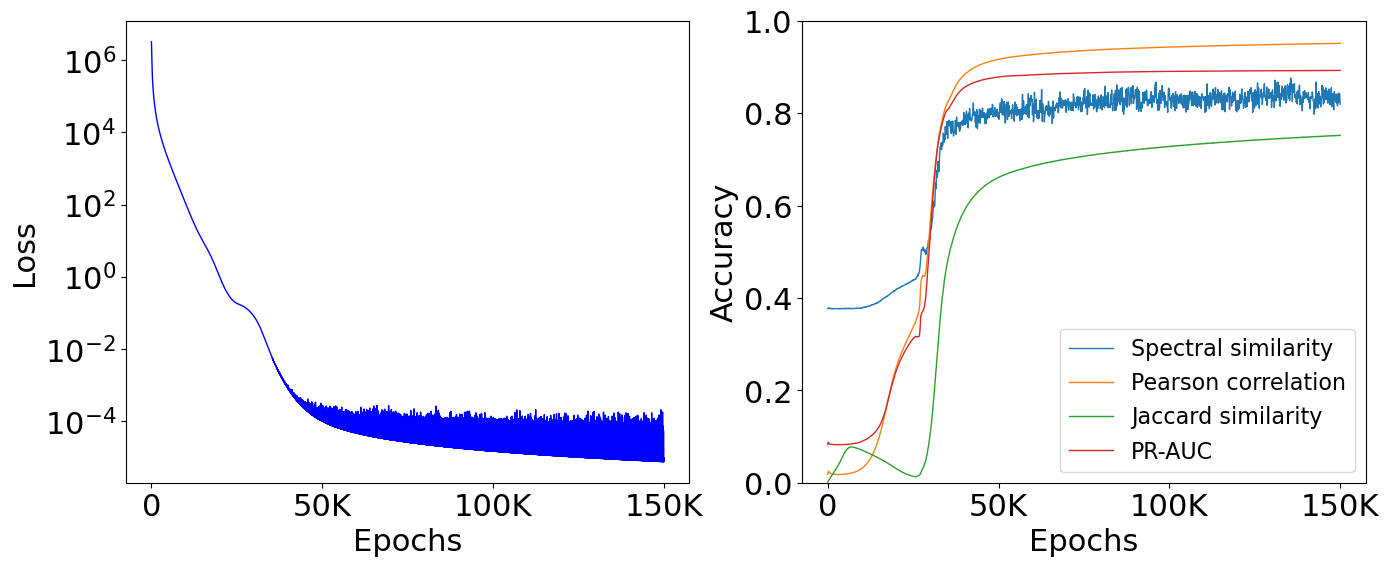

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey= False, figsize=(16, 6))
ax1.plot(loss, "b-", linewidth=1, label= "loss")
ax2.plot(ax2Xrange, evaluates, linewidth=1, label=evaluateMeth)
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '0' if x == 0 else '{:.0f}K'.format(x * 1e-3)))
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '0' if x == 0 else '{:.0f}K'.format(x * 1e-3)))
ax1.set_yscale("log")
ax1.set_xlabel("Epochs", fontsize= fontsize)
ax2.set_xlabel("Epochs", fontsize= fontsize)
ax1.set_ylabel("Loss", fontsize= fontsize)
ax2.set_ylabel("Accuracy", fontsize= fontsize)
ax2.set_ylim([0, 1])
# Set the font size of the x-axis tick labels
ax1.tick_params(axis='both', labelsize=22)
ax2.tick_params(axis='both', labelsize=22)
ax2.legend(fontsize= fontsize-6)
# ax1.legend(fontsize= fontsize-6)

In [5]:
#AA_WS_identical_11_4_-1_0_100_10.0_150000

identicalf= 0.01
node= 100
#Is - jaccard index
cosinesL= []
spectralsL= []
edgesL= []
jaccardsL= []
meanVL= [] 
varVL= [] 
simMatrixSumAVgL= []
for randomGraph in randomGraphs:
    for dense in denses:
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        for seed in seeds:
            try:
                fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_{strain}_-1_{dense}_{node}_{identicalf*1000}_150000.npz"
                IMatrix= torch.eye(node, device= "cpu")
                npzfile = np.load(fileName)
            except:
                print(fileName)
                continue
            # Access the arrays in the NPZ file
            Awnp= npzfile['A']
            PreAnp= npzfile['Apre']
            signal= npzfile['signal']
            meanV, varV, simMatrixSumAVg= analyse_signal(signal)
            meanVL.append(meanV)
            varVL.append(varV)
            simMatrixSumAVgL.append(simMatrixSumAVg)
            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int(torch.sum(Aw)/identicalf)  
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
            cosinesL.append(evaluate.cosine_similarity(Aw, PreA).item())
            spectralsL.append(evaluate. spectral_similarity(Aw, PreA).item())
            edgesL.append(evaluate.recall(Aw, PreA).item())
            jaccardsL.append(evaluate.jaccard_index(Aw, PreA).item())

results/AA/AA_RGG_identical_14_4_-1_-4_100_10.0_150000.npz


Pearson correlation: 0.75, spearma correlation: 0.48,  kendall correlation: 0.58


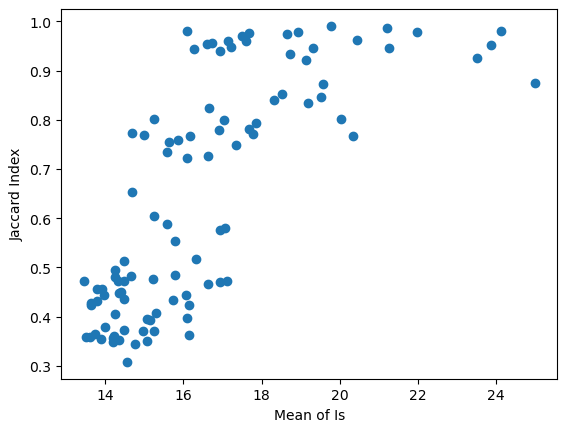

In [6]:
scatter_points(meanVL, jaccardsL, "Mean of Is","Jaccard Index" )

Pearson correlation: 0.68, spearma correlation: 0.68,  kendall correlation: 0.72


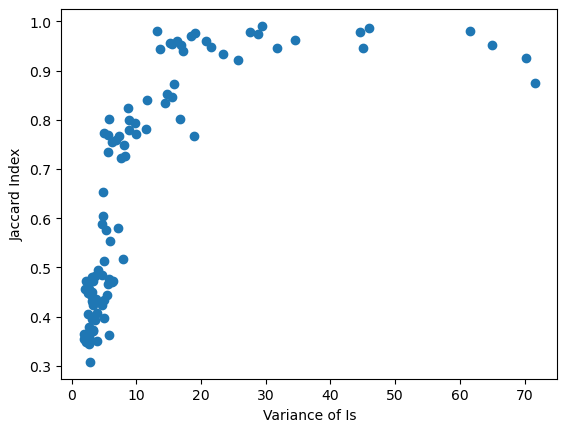

In [9]:
scatter_points(varVL, jaccardsL, "Variance of Is", "Jaccard Index" )

Pearson correlation: -0.94, spearma correlation: -0.70,  kendall correlation: -0.74


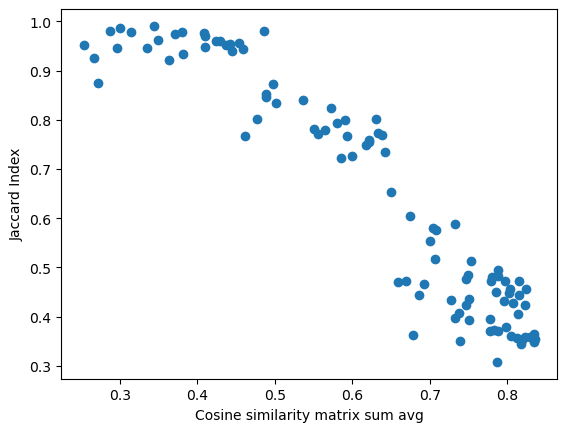

In [10]:
scatter_points(simMatrixSumAVgL, jaccardsL, "Cosine similarity matrix sum avg", "Jaccard Index" )

In [5]:
#train svm classier
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.svm import SVR  # For SVM regression

model = SVR(kernel='rbf')  # Adjust kernel as needed
x_train_np= np.stack(meanVL)
y_train_np= np.stack(varVL)
z_train_np= np.stack(simMatrixSumAVgL)
g_train_np= np.stack(jaccardsL)
model.fit(np.stack([x_train_np, y_train_np, z_train_np], axis=1), g_train_np)

g_pred_np = model.predict(np.stack([x_train_np, y_train_np, z_train_np], axis=1))

print(np.mean(np.abs(g_train_np-g_pred_np)))
print(np.var(np.abs(g_train_np-g_pred_np)))

NameError: name 'meanVL' is not defined

In [99]:
import modules.random_graph as random_graph
import modules.pramameters as pramameters
import modules.utils as utils
import modules.weight as weight
import modules.A_mat as A_mat
import modules.population as population
import modules.simulation as simulation
import argparse
import math
from tqdm import tqdm

#Changeable parameters 
parser = argparse.ArgumentParser(description='Topology fitting parameters')
pramameters.add_arguments(parser)
paras= pramameters.read_arguments(parser)
#preset
paras.modelLoad= "AA"
paras.randomGraph= "ER"
paras.weightModel= "identical"
paras.epoches= 100000
paras.intense= 0#0:
paras.plot= "spring"
paras.strains= 4
paras.dense= 2
paras.identicalf= 0.01
paras.n= 100
paras.seed= 11

if paras.dense<=0:
    paras.dense= int(math.log(paras.n))-paras.dense
    print(paras.dense)

lenths= []

for i in tqdm(range(2, 40)):
    paras.dense= i

    if paras.randomGraph not in randomGraphs:
        print("haha")
        A, G= random_graph.read_from_file("graphs/"+paras.randomGraph+".npy")
    else:
        A, G= random_graph.get_ER_random_contact(paras.n, paras.dense)

    P= population.population(paras.n)

    Aw= weight.identical_model(A, paras.identicalf)

    Zmat= A_mat.create_A_mat(Aw, P)

    R0s_taus= [[random.uniform(paras.R0Mean-paras.R0Std, paras.R0Mean+paras.R0Std), 
                random.uniform(paras.tauMean-paras.tauStd, paras.tauMean+paras.tauStd)] for _ in range(40)]
    paras.R0s=  [ R0s_taus[i][0] for i in range(40)]
    paras.taus= [ R0s_taus[i][1] for i in range(40)]

    deltaSsTensor= simulation.multi_strains(G, paras, Zmat, intense= paras.intense, lower= 5)
    deltaSs= deltaSsTensor.sum(dim= -1, keepdim= True)
    propition= deltaSsTensor/(deltaSs+1e-8)
    deltaSs= deltaSs.squeeze()#(1, 2, 20), dim of nodes, dim of heads, dim of signal
    divide= deltaSsTensor.transpose(1, 2)

    meanV, varV, simMatrixSumAVg= analyse_signal(divide.numpy())
    lenths.append(divide.shape[-1])
print(meanV, varV, simMatrixSumAVg)
print(divide.shape[-1])
print(model.predict(np.array([[meanV, varV, simMatrixSumAVg]])))


100%|██████████| 38/38 [00:04<00:00,  8.05it/s]

9.1275 0.17124374999999997 0.988134765625
12
[0.45279788]


In [46]:
# from datetime import datetime
# timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# # Specify the file path
# file_path = f"graphs/er3.npy"
# # Save the matrix to a file
# np.save(file_path, A.numpy())
# print(f"NumPy matrix saved to file: {file_path}")

NumPy matrix saved to file: graphs/er3.npy


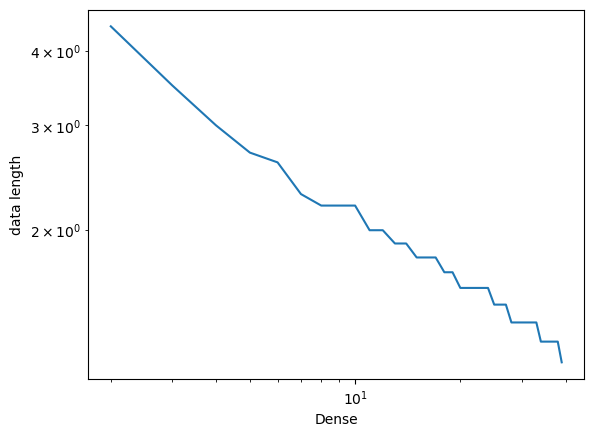

In [101]:
plt.plot([i for i in range(2, 40)], [i/10 for i in lenths])#y=log(x)
plt.xlabel("Dense")
plt.ylabel("data length")
plt.xscale("log")
plt.yscale("log")

In [20]:
print(modelLoads)

['AA', 'AB', 'BA', 'BB', 'infer2018']


In [43]:

identicalf= 0.01
node= 100
strain= 4
print("y:", modelLoads)
print("x:",randomGraphs)
#Performance on different models
for modelLoad in modelLoads:
    spectralsList= []
    pearsonList= []
    jaccardList= []
    ROCList= []
    PRList= []
    for randomGraph in randomGraphs:
        spectrals= 0
        pearsons= 0
        jaccards= 0
        ROCs= 0
        PRs= 0
        minus= 0
        for seed in seeds:
            try:
                fileName= f"results/{modelLoad}/{modelLoad}_{randomGraph}_identical_{seed}_{strain}_-1_0_{node}_{identicalf*1000}_150000.npz"
                if modelLoad== "CosSim":
                    fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_{strain}_-1_0_{node}_{identicalf*1000}_150000.npz"
                IMatrix= torch.eye(node, device= "cpu")
                npzfile = np.load(fileName)
            except:
                print(fileName)
                minus+=1
                continue
            # Access the arrays in the NPZ file
            Awnp= npzfile['A']
            PreAnp= npzfile['Apre']
            if modelLoad== "CosSim":
                signalOrigin= npzfile["signal"]
                signalOrigin= signalOrigin.reshape(signalOrigin.shape[0], signalOrigin.shape[1]*signalOrigin.shape[2])
                PreAnp= signalOrigin@signalOrigin.T/(1e-6+np.linalg.norm(signalOrigin, 2, 1, True)*np.linalg.norm(signalOrigin.T, 2, 0, True))
            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int(torch.sum(Aw)/identicalf)  
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))
            
            spectrals+= evaluate.spectral_similarity(Aws, PreAs)
            pearsons+= evaluate.pearson_correlation(Aws, PreAs)
            jaccards+= evaluate.jaccard_similarity(Aws, PreAs)
            ROCs+= evaluate.ROC_AUC(Aws, PreAs)
            PRs+= evaluate.PR_AUC(Aw, PreAs)
        spectrals/= len(seeds)-minus
        pearsons/= len(seeds)-minus
        jaccards/= len(seeds)-minus
        ROCs/= len(seeds)-minus
        PRs/= len(seeds)-minus
        spectralsList.append(f"{np.abs(spectrals):.2f}")
        pearsonList.append(f"{np.abs(pearsons):.2f}")
        jaccardList.append(f"{jaccards:.2f}")
        ROCList.append(f"{ROCs:.2f}")
        PRList.append(f"{PRs:.2f}")
        #print(f"{cosines:.2f}\t{spectrals:.2f}\t{edges:.2f}\t{jaccards:.2f}", end="\t")
    print(" ".join(spectralsList)+"\t"+" ".join(pearsonList)+"\t"+" ".join(jaccardList)+"\t"+" ".join(ROCList)+"\t"+" ".join(PRList))
    #print()

y: ['AA', 'AB', 'BA', 'BB', 'infer2018', 'CosSim']
x: ['ER', 'BA', 'WS', 'RGG']
0.10 0.02 0.75 0.82	0.53 0.66 0.88 0.96	0.39 0.52 0.80 0.93	0.73 0.79 0.89 0.93	0.56 0.66 0.85 0.92
0.04 0.05 0.15 0.20	0.00 0.01 0.00 0.02	0.04 0.05 0.04 0.05	0.50 0.50 0.50 0.51	0.12 0.13 0.12 0.14
0.05 0.00 0.01 0.01	0.03 0.05 0.13 0.17	0.05 0.06 0.11 0.13	0.51 0.52 0.55 0.57	0.14 0.15 0.22 0.26
0.04 0.01 0.01 0.08	0.01 0.02 0.07 0.16	0.05 0.05 0.08 0.13	0.50 0.50 0.53 0.56	0.13 0.13 0.17 0.25
0.01 0.01 0.03 0.04	0.02 0.02 0.07 0.13	0.05 0.05 0.08 0.11	0.50 0.50 0.52 0.55	0.14 0.13 0.17 0.23
0.09 0.02 0.56 0.67	0.02 0.03 0.33 0.51	0.05 0.03 0.24 0.39	0.56 0.54 0.71 0.79	0.24 0.21 0.51 0.66


In [12]:
#epidemic prediction accuracy
identicalf= 0.01
node= 100
strain= 4
realGraphsTemp= ["mobility_us", "contious_usa", "global_air", "spain_car", "spain_train"]
realgraphs0805= \
["us_air100", "us_air200", "us_air300", "us_air400", "spain_bus", "spain_plane", "contious_Africa", "contious_china", "contious_EU", "mobility_german"]

#Performance on different models
for modelLoad in ["AB"]:
    
    acctausAVGList= []
    accrosAVGList= []
    for randomGraph in ["us_air200", "us_air300", "us_air400", "mobility_german", "global_air"]:
        acctausAVG= 0
        accrosAVG= 0
        for seed in [11]:
            try:
                fileName= f"results/{modelLoad}/{modelLoad}_{randomGraph}_identical_{seed}_{strain}_-1_0_{node}_{identicalf*1000}_10000.npz"
                IMatrix= torch.eye(node, device= "cpu")
                npzfile = np.load(fileName)
            except:
                print(fileName)
                continue
            # Access the arrays in the NPZ file
            taus= npzfile['taus'][0: strain]
            r0s= npzfile['r0s'][0: strain]
            gamasIv= taus
            betas= r0s/taus
            tausP= npzfile['tausP']
            r0sP= npzfile['r0sP']
            tausP= np.nanmean(tausP, axis=0)
            r0sP= np.nanmean(r0sP, axis= 0)

            gamasPIv= tausP
            betasP= r0sP/(tausP+1e-6)
            acctaus= np.nanmean(np.sqrt(np.square(betas-betasP)))
            accros= np.nanmean(np.sqrt(np.square(gamasIv-gamasPIv)))
            acctausAVG+= acctaus
            accrosAVG+= accros
        acctausAVG/= len(seeds)
        accrosAVG/= len(seeds)
        acctausAVGList.append(f"{acctausAVG:.2f}")
        accrosAVGList.append(f"{accrosAVG:.2f}")
        #print(f"{cosines:.2f}\t{spectrals:.2f}\t{edges:.2f}\t{jaccards:.2f}", end="\t")
    print("\t".join(accrosAVGList)+"\t")
    #print()

0.52	0.68	0.76	1.00	0.52	


In [7]:
def general_evaluate(evaluateMeth=[], attriIndex= 0, attributionL=[] ,seed= 100001, CompareWithRandom= False, seeds= [], randomGraphs= [], modelLoad= "AA"):
    random.seed(seed)
    strain= 4
    intense= -1
    dense= 0
    node= 100
    identicalf= 0.01
    epoches= 150000
    
    atts= [strain, intense, dense, node, identicalf, epoches, modelLoad]
    auc_rocs_aws= []
    auc_rocs_preA= []
    evaluateLists= []
    for randomGraph in randomGraphs:
        evaluateList= []
        for attribution in attributionL: 
            atts[attriIndex]= attribution
            evaluateNp= [torch.tensor([0.0]) for _ in range(len(evaluateMeth))]
            auc_rocs_aws_temp= []
            auc_rocs_preA_temp= []
            addNum= 1e-6
            for seed in seeds:
                fileName= f"results/{atts[6]}/{atts[6]}_{randomGraph}_identical_{seed}_{atts[0]}_{atts[1]}_{atts[2]}_{atts[3]}_{atts[4]*1000}_{atts[5]}.npz"
                if atts[6]=="base":
                    fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_{atts[0]}_{atts[1]}_{atts[2]}_{atts[3]}_{atts[4]*1000}_{atts[5]}.npz"
                try:
                    npzfile = np.load(fileName)
                except:
                    #print(fileName)
                    continue
                # Access the arrays in the NPZ file
                Awnp= npzfile['A']
                node= Awnp.shape[0]
                IMatrix= torch.eye(node, device= "cpu")
                PreAnp= npzfile['Apre']
                if CompareWithRandom or atts[6]=="base":
                    denseTrue= int(math.log(node))-atts[2]
                    A, _= random_graph.get_ER_random_contact(node, denseTrue, shuffle= True)
                    PreAnp= A.numpy()
                Aw = torch.tensor(Awnp)
                PreA = torch.tensor(PreAnp)
                
                links= int(torch.sum(Aw)/identicalf)  
                Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
                if torch.isnan(PreA).any() == False:
                    for i, method in enumerate(evaluateMeth):
                        evaluateNp[i]+= method(Aw, PreA)
                    addNum+=1
                auc_rocs_aws_temp.append(Aws-IMatrix)
                auc_rocs_preA_temp.append(PreA)
            try:
                for i, _ in enumerate(evaluateMeth):
                    evaluateNp[i]= round(evaluateNp[i].item()/addNum, 2)
                evaluateList.append(evaluateNp)
                auc_rocs_aws.append(torch.stack(auc_rocs_aws_temp))
                auc_rocs_preA.append(torch.stack(auc_rocs_preA_temp))
            except:
                continue
        strPrint=""
        evaluateLists.append(evaluateList)
        zipList= list(zip(*evaluateList))
        for i, _ in enumerate(evaluateMeth):#attributionL, evaluateList(evaluateMeth, zipList)
            strPrint+= " ".join([str(j) for j in zipList[i]])+"   "
        print(randomGraph+" "+strPrint)
    return auc_rocs_aws, auc_rocs_preA, evaluateLists

def plot_evaluate(xs, evaluateArray, xLabel, yLabels, legends, xScale="linear", yScale="linear"):
    col= len(legends)
    fontsize= 34
    fig, axs = plt.subplots(int((len(yLabels)+col-1)/col), col, figsize=(col*8, 8*int((len(yLabels)+col-1)/col)))
    for i, yLabel in enumerate(yLabels):
        axs[i%col].plot(xs , evaluateArray[:, :, i].T)
        axs[i%col].set_xlabel(xLabel, fontsize= fontsize)
        yLabel= str(yLabel).replace("_", " ")
        yLabel= yLabel[0].capitalize()+yLabel[1:]
        
        axs[i%col].set_ylabel(yLabel, fontsize= fontsize)
        axs[i%col].set_xscale(xScale)
        axs[i%col].set_yscale(yScale)
        axs[i%col].tick_params(axis='both', labelsize=fontsize)
        
    axs[i%col].legend(legends, fontsize= fontsize-5)
    plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


us_air200 0.0   0.0   0.0   0.0   
us_air300 0.0   0.0   0.0   0.0   
us_air400 0.0   0.0   0.0   0.0   
mobility_german 0.0   0.0   0.0   0.0   
global_air 0.0   0.0   0.0   0.0   


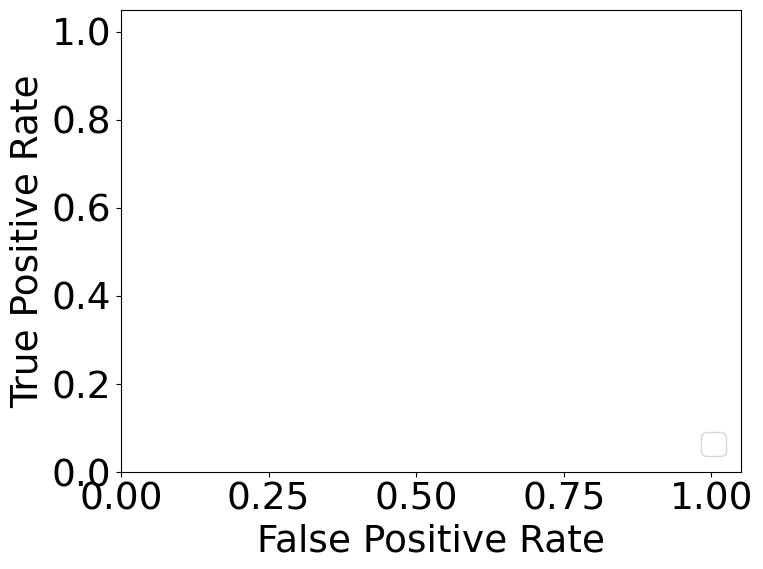

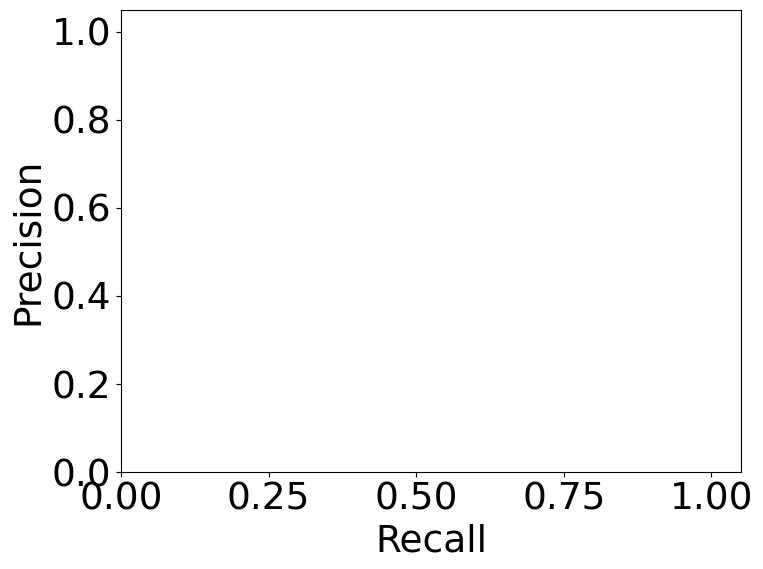

In [8]:
#[strain, intense, dense, node, identicalf, epoches, modelLoad]
realGraphsTemp= ["mobility_us", "contious_usa", "global_air", "spain_car", "spain_train"]
realgraphs0805= ["us_air100", "spain_bus", "spain_plane", "contious_Africa", "contious_china", "contious_EU", "mobility_german"]
realgraphs0812= ["us_air200", "us_air300", "us_air400", "mobility_german", "global_air"]
evaluateMeth= [evaluate.spectral_similarity, evaluate.pearson_correlation, evaluate.jaccard_similarity, evaluate.PR_AUC]
attriIndex= 6
attributionL= ["AB"]
auc_rocs_aws, auc_rocs_preA, evaluateLists= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= attriIndex, attributionL= attributionL ,seed= 100001, CompareWithRandom= False, seeds=[11], randomGraphs= realgraphs0812)
evaluateArray= np.array(evaluateLists)
startIn= 0*len(attributionL)
endIn= len(attributionL)+startIn
evaluate.draw_auc_roc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)
evaluate.draw_prc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)
yLabels= [str(i).split()[1] for i in evaluateMeth]

mobility_us -0.57   0.06   0.0   0.01   
contious_usa 0.84   0.17   0.01   0.01   
global_air 0.0   0.0   0.0   0.0   
spain_car 0.82   0.08   0.02   0.01   
spain_train -0.81   0.06   0.01   0.01   


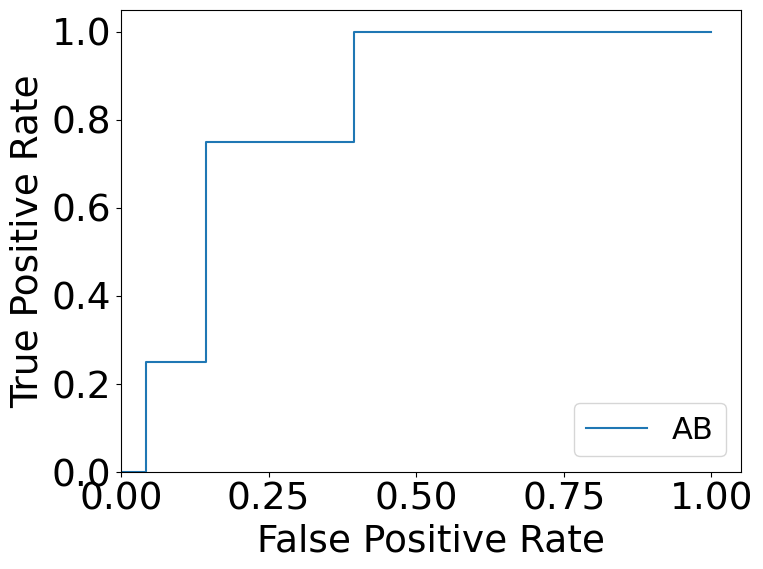

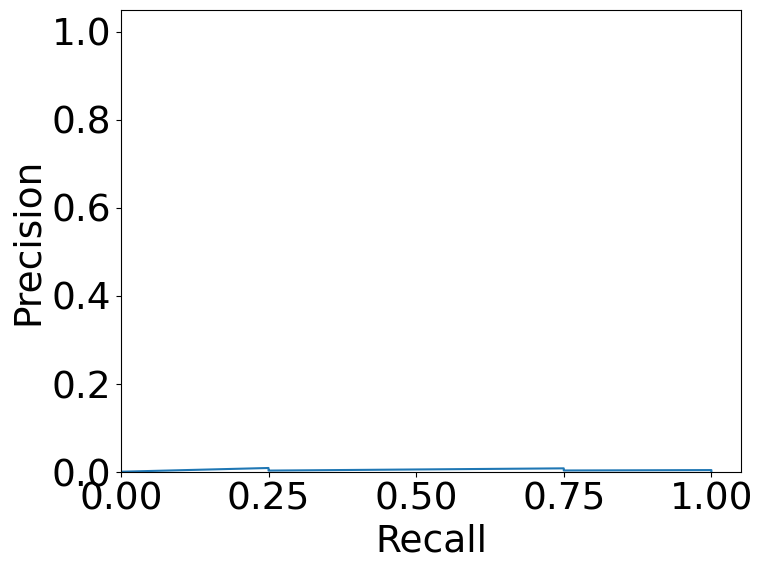

In [9]:
#[strain, intense, dense, node, identicalf, epoches, modelLoad]
evaluateMeth= [evaluate. spectral_similarity, evaluate.pearson_correlation, evaluate.jaccard_similarity, evaluate.PR_AUC]
attriIndex=  6
realGraphsTemp= ["mobility_us", "contious_usa", "global_air", "spain_car", "spain_train"]
attributionL= ["AB"]
auc_rocs_aws, auc_rocs_preA, evaluateLists= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= attriIndex, attributionL= attributionL ,seed= 100001, CompareWithRandom= False, seeds=seeds, randomGraphs= realGraphsTemp)
evaluateArray= np.array(evaluateLists)
startIn= 0*len(attributionL)
endIn= len(attributionL)+startIn
evaluate.draw_auc_roc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)
evaluate.draw_prc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)
yLabels= [str(i).split()[1] for i in evaluateMeth]

ValueError: x and y must have same first dimension, but have shapes (4,) and (1, 5)

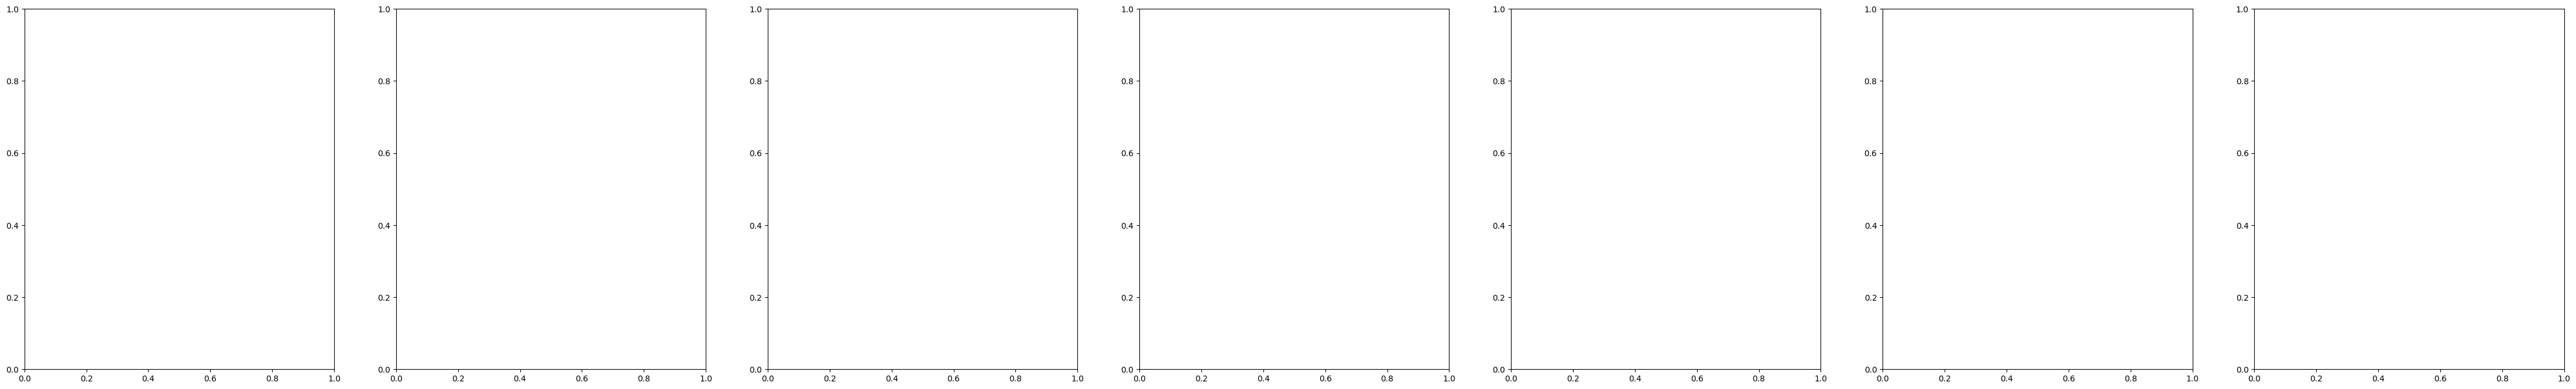

In [10]:
plot_evaluate( strains, evaluateArray, "strains", yLabels, realGraphs)

ER 0.01 1.0 -0.2 -0.2   0.11 0.44 0.51 0.62   0.05 0.14 0.19 0.25   0.0 0.0 0.0 0.0   
BA 0.42 0.2 -0.6 0.2   0.23 0.52 0.63 0.72   0.09 0.19 0.26 0.34   0.0 0.0 0.0 0.0   
WS 0.49 -0.2 -0.6 -0.2   0.2 0.67 0.8 0.88   0.08 0.31 0.46 0.58   0.0 0.0 0.0 0.0   
RGG -0.18 0.34 -0.04 0.58   0.19 0.8 0.92 0.95   0.06 0.47 0.67 0.75   0.0 0.0 0.0 0.0   
haha


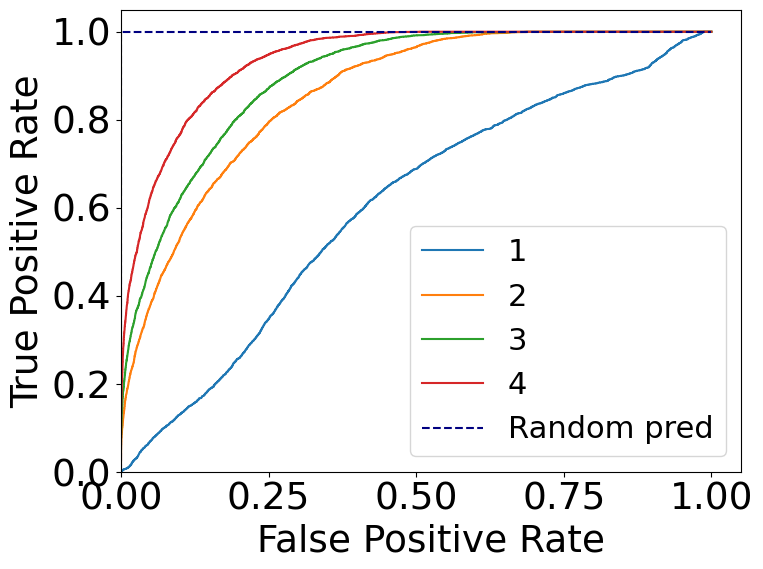

In [10]:
#[strain, intense, dense, node, identicalf, epoches]
evaluateMeth= [ evaluate. spectral_similarity, evaluate.pearson_correlation, evaluate.jaccard_similarity, evaluate.PR_AUC]
attriIndex= 0 
attributionL= strains
auc_rocs_aws, auc_rocs_preA, evaluateLists= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= attriIndex, attributionL= attributionL ,seed= 100001, CompareWithRandom= False, seeds= seeds, randomGraphs= randomGraphs)
evaluateArray= np.array(evaluateLists)
startIn= 0*len(attributionL)
endIn= len(attributionL)+startIn

evaluate.draw_auc_roc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL, random_real_pre= auc_rocs_aws[startIn: endIn])
# evaluate.draw_prc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL, random_real_pre)

['spectral_similarity', 'pearson_correlation', 'jaccard_similarity', 'PR_AUC']


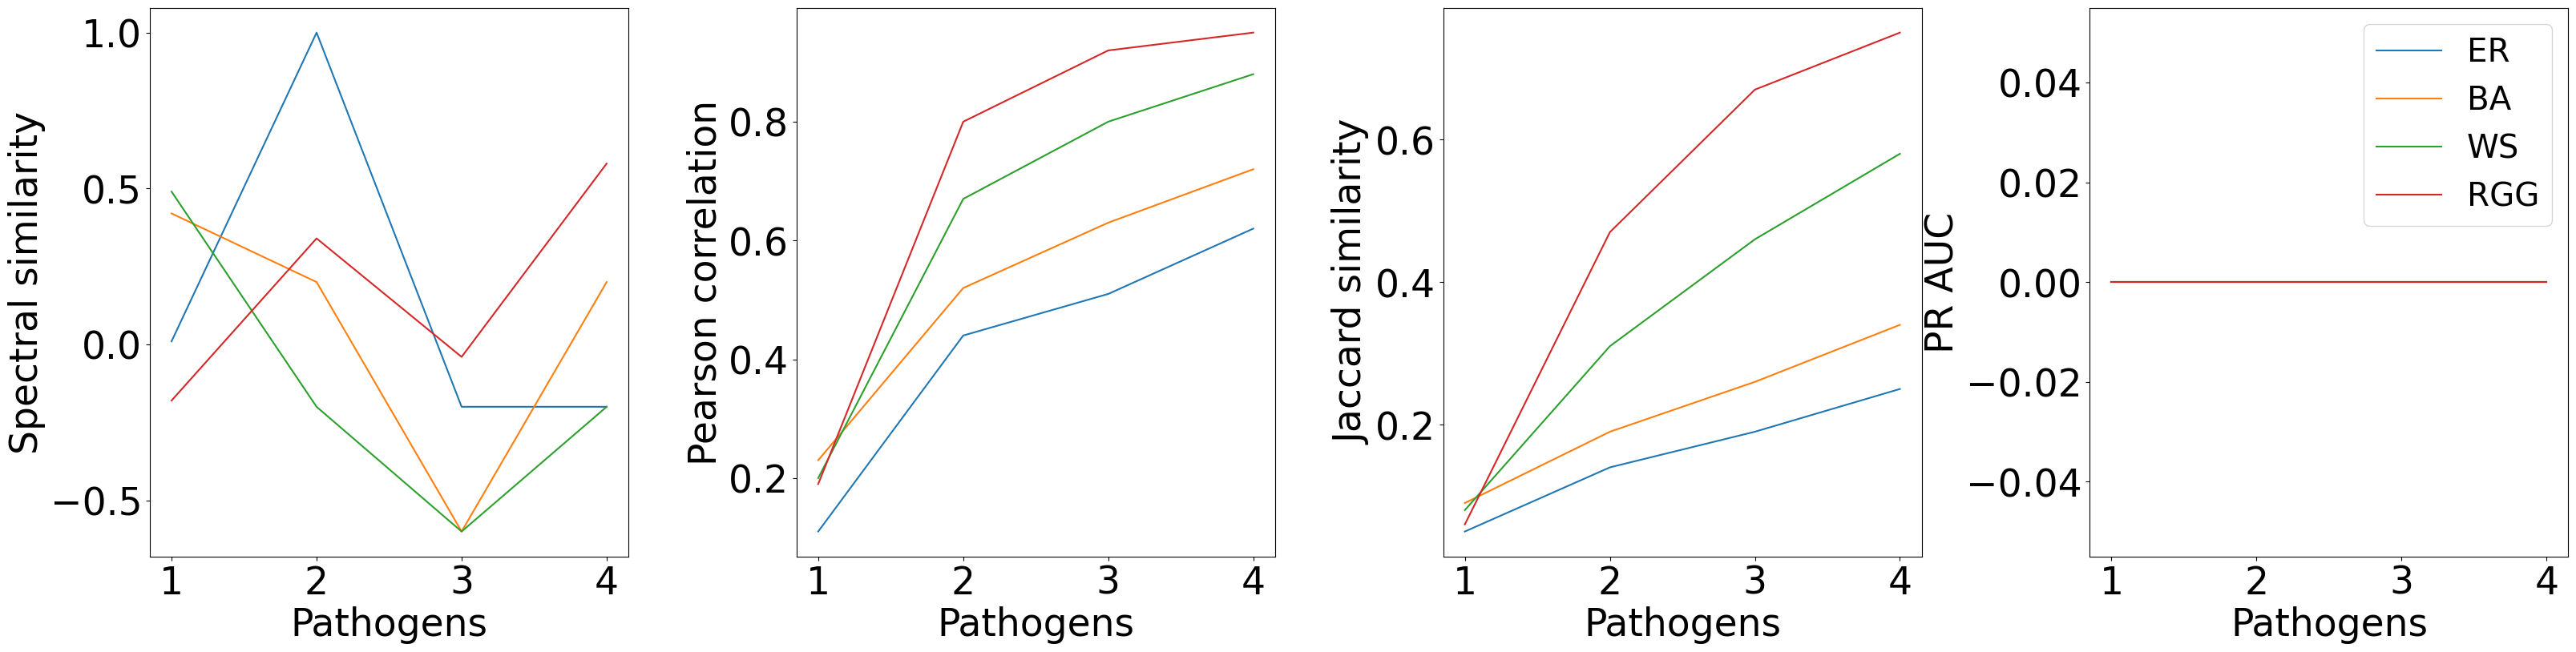

In [11]:
yLabels= [str(i).split()[1] for i in evaluateMeth]
print(yLabels)
plot_evaluate(strains, evaluateArray, "Pathogens", yLabels, randomGraphs)

In [26]:
#bentch mark on real graphs
#[strain, intense, dense, node, identicalf, epoches]
evaluateMeth= [ evaluate. spectral_similarity, evaluate.pearson_correlation, evaluate.jaccard_similarity,evaluate.ROC_AUC, evaluate.PR_AUC]
attriIndex= 0 
attributionL= [4]
realGraphs1= ["contious_Africa", "contious_china", "contious_EU", "contious_usa", "mobility_german", "mobility_us"]
realGraphs2= ["global_air", "us_air"]
realGraphs3= ["us_air100", "us_air200", "us_air300", "us_air400", "spain_bus", "spain_car", "spain_plane", "spain_train"]
realGraphsAll= realGraphs1+realGraphs2+realGraphs3
auc_rocs_aws, auc_rocs_preA, evaluateLists= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= attriIndex, attributionL= attributionL  
 ,seed= 100001,CompareWithRandom= False, seeds= [11], randomGraphs= realGraphsAll, modelLoad="infer2018")
evaluateArray= np.array(evaluateLists)
startIn= 0*len(attributionL)
endIn= len(attributionL)+startIn

0.44	0.19	0.02	0.57	0.15	
0.5	0.25	0.02	0.59	0.23	
0.51	0.19	0.02	0.5	0.2	
0.4	0.17	0.02	0.54	0.15	
results/infer2018/infer2018_mobility_german_identical_11_4_-1_0_100_10.0_150000.npz
0.0	0.0	0.0	0.0	0.0	
0.43	0.06	0.0	0.5	0.77	
0.01	0.1	0.01	0.56	0.07	
0.0	0.11	0.01	0.59	0.05	
0.61	0.13	0.02	0.57	0.14	
0.61	0.14	0.01	0.61	0.1	
results/infer2018/infer2018_us_air300_identical_11_4_-1_0_100_10.0_150000.npz
0.0	0.0	0.0	0.0	0.0	
results/infer2018/infer2018_us_air400_identical_11_4_-1_0_100_10.0_150000.npz
0.0	0.0	0.0	0.0	0.0	
0.62	0.05	0.02	0.43	0.1	
0.46	0.09	0.02	0.48	0.11	
0.76	0.28	0.03	0.62	0.28	
0.63	0.06	0.02	0.44	0.1	


ER 0.2 0.2 0.6 -0.2   0.62 0.62 0.6 0.62   0.25 0.25 0.24 0.25   0.83 0.83 0.83 0.83   0.0 0.0 0.0 0.0   
BA 0.6 -1.0 0.2 -0.2   0.72 0.72 0.71 0.72   0.34 0.34 0.33 0.34   0.86 0.85 0.85 0.85   0.0 0.0 0.0 0.0   
WS 0.2 0.6 0.6 -0.59   0.89 0.89 0.89 0.88   0.59 0.59 0.6 0.58   0.89 0.89 0.89 0.89   0.0 0.0 0.0 0.0   
RGG -0.2 0.6 -0.2 -0.58   0.96 0.97 0.94 0.95   0.79 0.8 0.72 0.75   0.89 0.89 0.89 0.89   0.0 0.0 0.0 0.0   


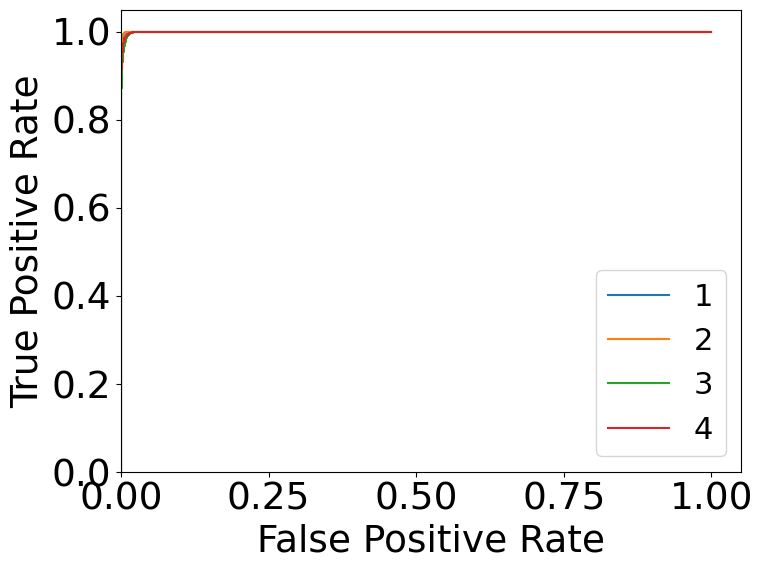

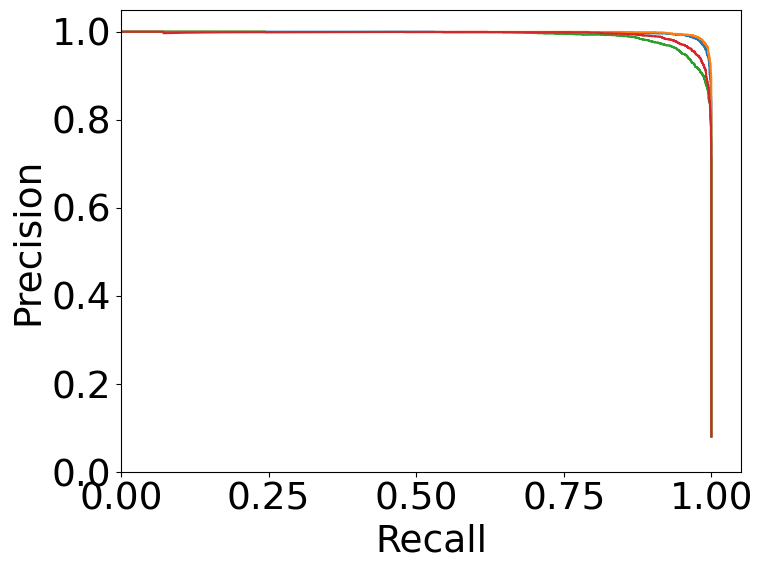

In [13]:
#[strain, intense, dense, node, identicalf, epoches]
evaluateMeth= [  evaluate. spectral_similarity, evaluate.pearson_correlation, evaluate.jaccard_similarity,evaluate.ROC_AUC, evaluate.PR_AUC]
auc_rocs_aws, auc_rocs_preA, evaluateLists= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= 1, attributionL=intenses ,seed= 100001, CompareWithRandom= False, seeds= seeds, randomGraphs= randomGraphs)
evaluateArray= np.array(evaluateLists)

startIn= 3*len(attributionL)
endIn= len(attributionL)+startIn
yLabels= [str(i).split()[1] for i in evaluateMeth]

evaluate.draw_auc_roc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)
evaluate.draw_prc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

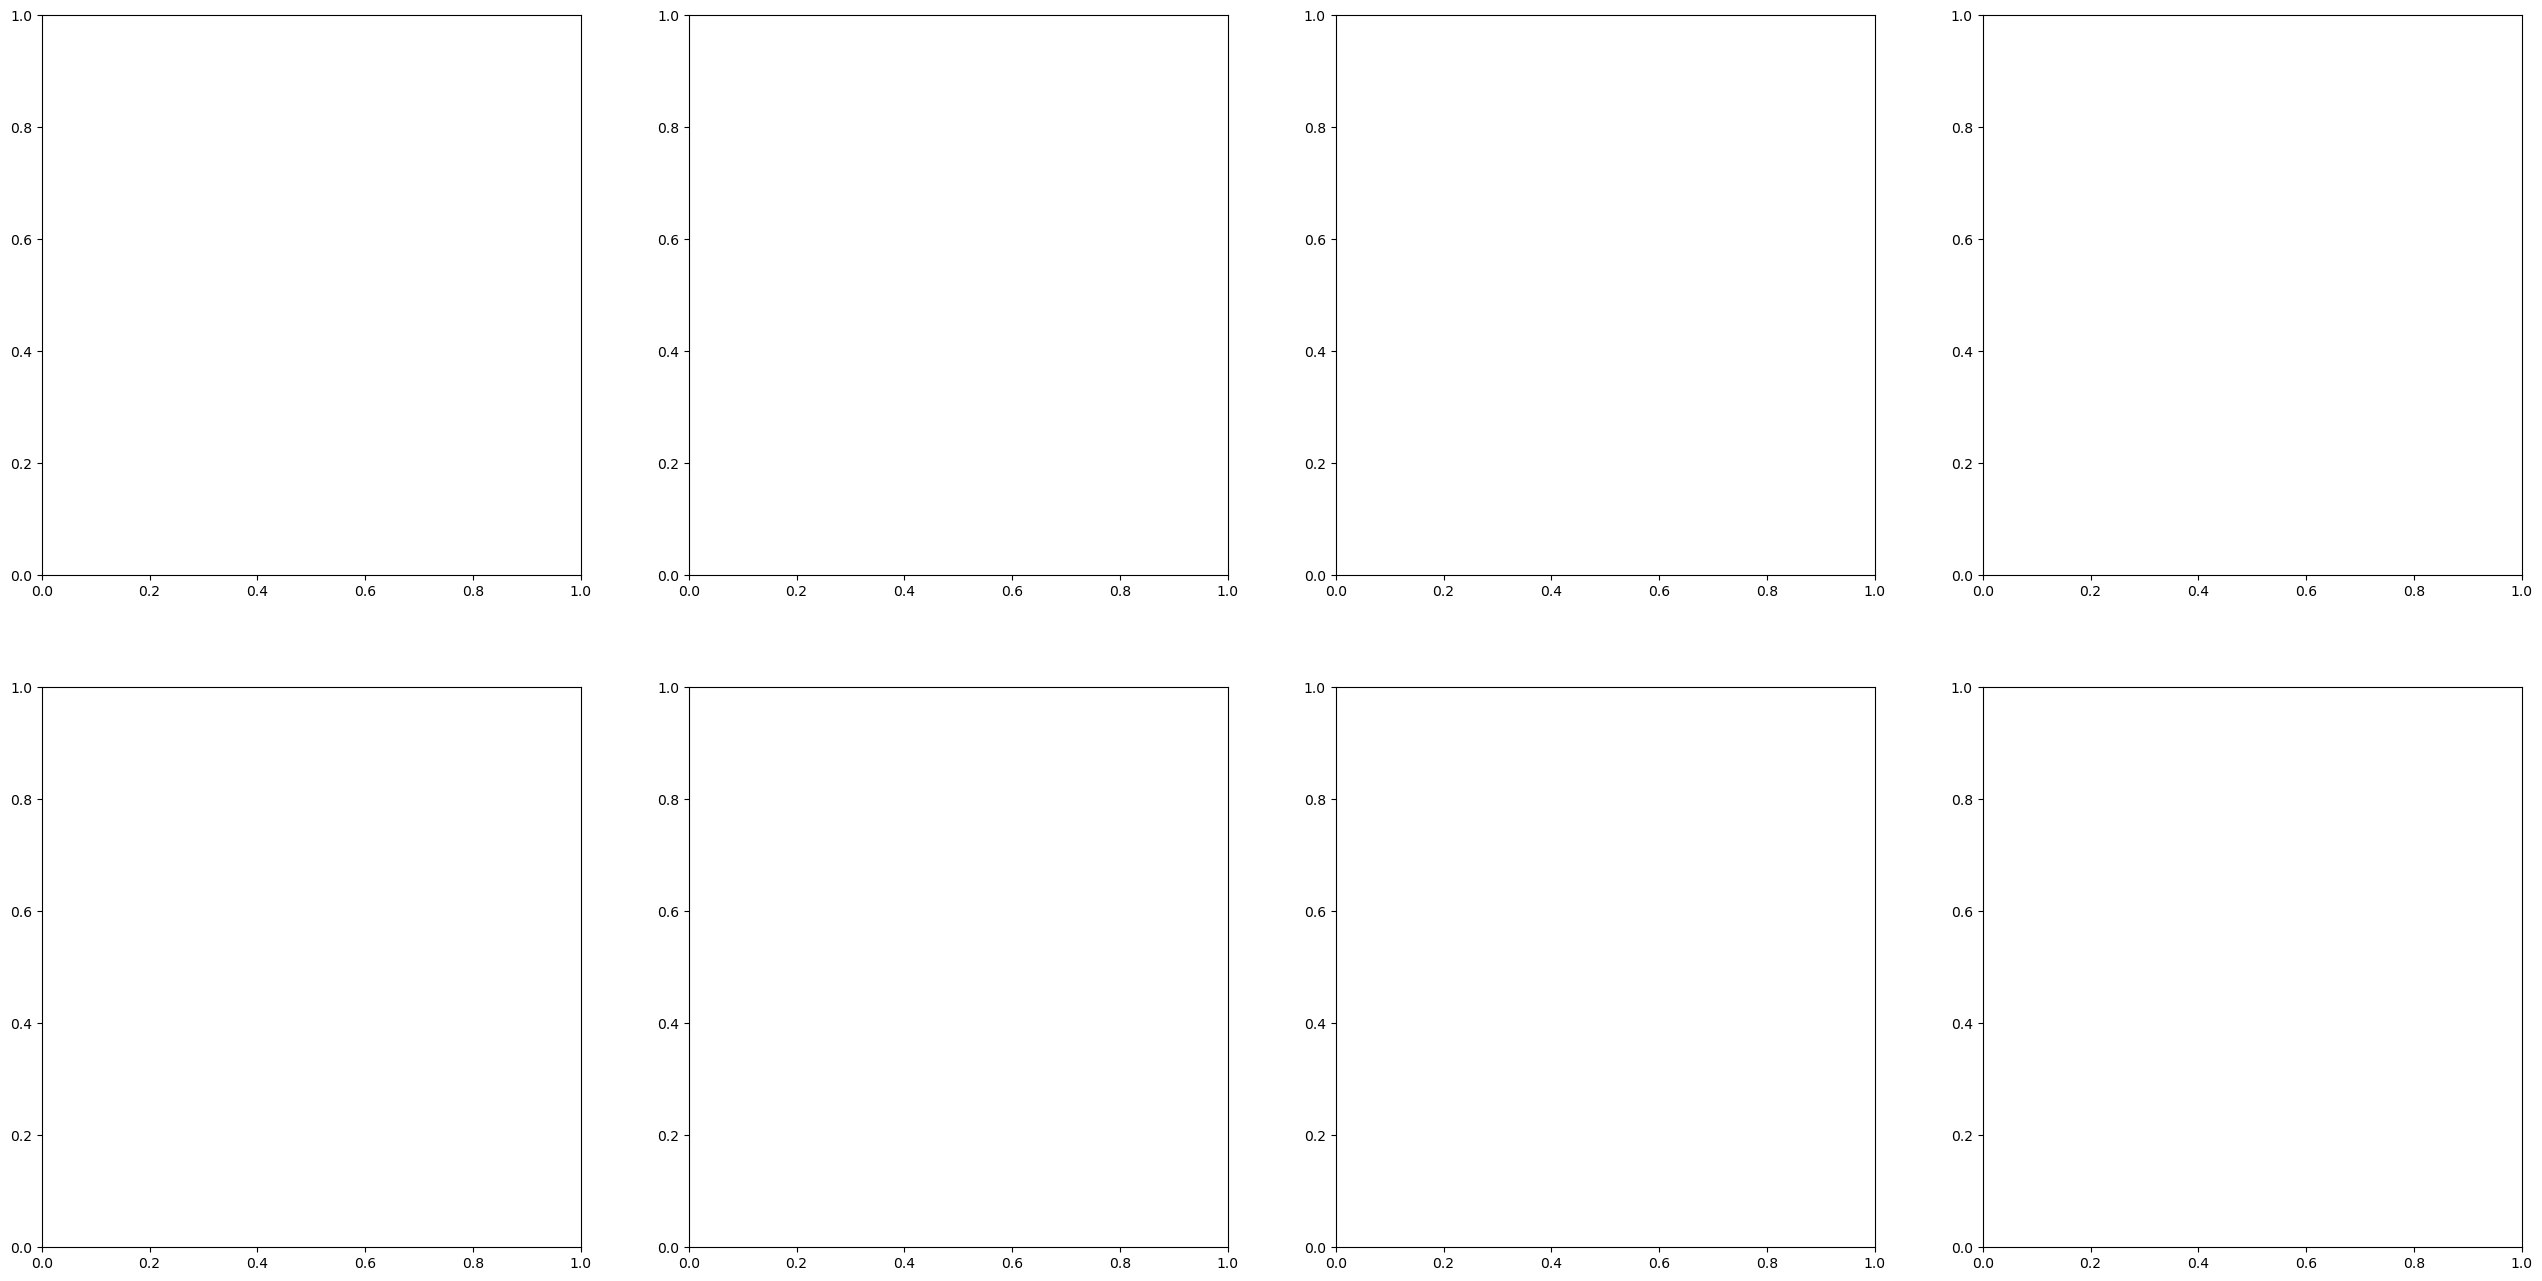

In [14]:
plot_evaluate([-1, 0, 1, 2], evaluateArray, "Intense", yLabels, randomGraphs)

ER -0.2 0.2 -0.2 0.6 0.6   0.62 0.56 0.52 0.51 0.49   0.25 0.23 0.21 0.22 0.22   0.0 0.0 0.0 0.0 0.0   
BA 0.2 -0.2 1.0 -0.6 -0.6   0.72 0.63 0.64 0.6 0.59   0.34 0.28 0.29 0.28 0.27   0.0 0.0 0.0 0.0 0.0   
WS -0.2 0.2 0.2 1.0 -0.2   0.88 0.87 0.84 0.82 0.79   0.58 0.57 0.54 0.52 0.5   0.0 0.0 0.0 0.0 0.0   
RGG 0.58 -0.19 -0.2 0.2 0.2   0.95 0.96 0.95 0.95 0.94   0.75 0.76 0.76 0.75 0.73   0.0 0.0 0.0 0.0 0.0   


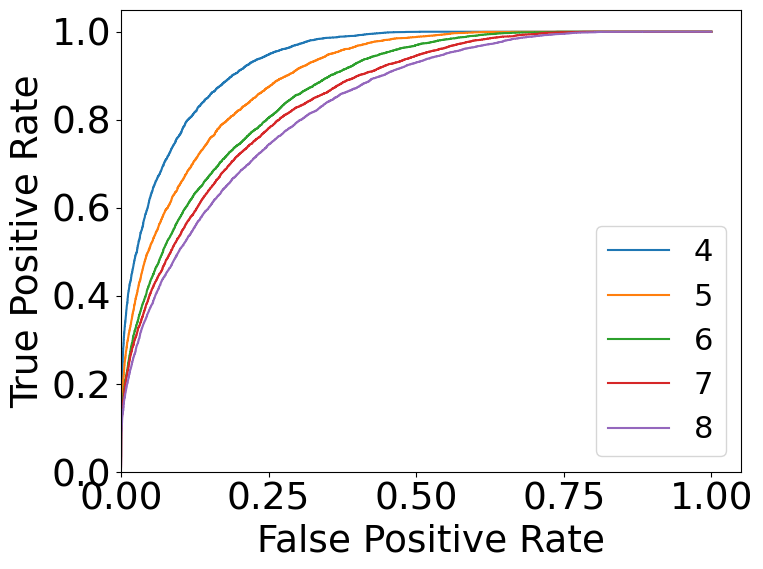

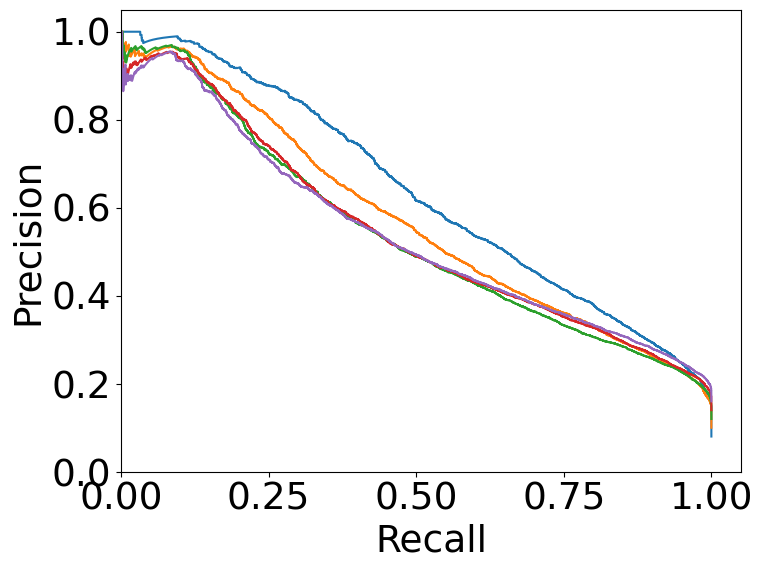

In [12]:
#[strain, intense, dense, node, identicalf, epoches]
evaluateMeth= [  evaluate.spectral_similarity, evaluate.pearson_correlation, evaluate.jaccard_similarity, evaluate.PR_AUC]
auc_rocs_aws, auc_rocs_preA, evaluateLists= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= 2, attributionL= denses ,seed= 100001, CompareWithRandom= False, seeds= seeds, randomGraphs= randomGraphs)
evaluateArray= np.array(evaluateLists)
attributionL= denses
startIn= 0*len(attributionL)
endIn= len(attributionL)+startIn
yLabels= [str(i).split()[1] for i in evaluateMeth]
evaluate.draw_auc_roc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], int(math.log(100))-np.array(denses))
evaluate.draw_prc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], int(math.log(100))-np.array(denses))

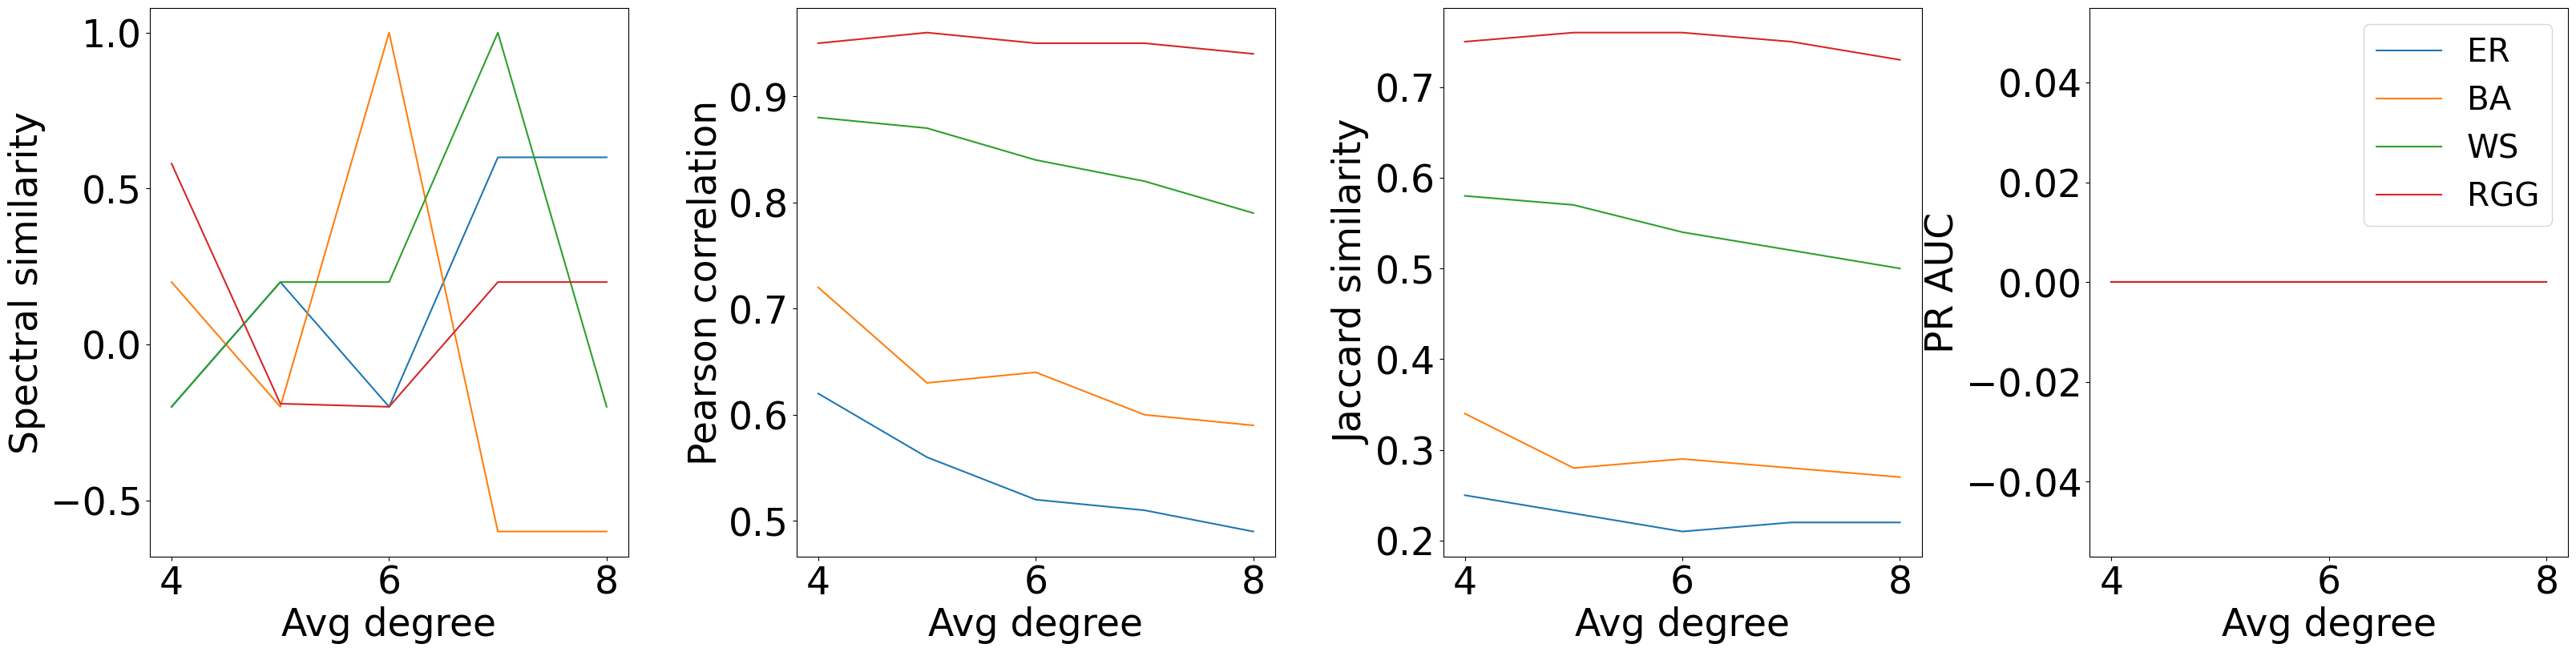

In [13]:
plot_evaluate(int(math.log(100))-np.array(denses), evaluateArray, "Avg degree", yLabels, randomGraphs)

In [14]:
#[strain, intense, dense, node, identicalf, epoches]
evaluateMeth= [  evaluate. spectral_similarity, evaluate.pearson_correlation, evaluate.jaccard_similarity, evaluate.PR_AUC]
auc_rocs_aws, auc_rocs_preA, evaluateLists= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= 3, attributionL= nodes ,seed= 100001, CompareWithRandom= False, seeds= seeds, randomGraphs= randomGraphs)
evaluateArray= np.array(evaluateLists)
yLabels= [str(i).split()[1] for i in evaluateMeth]

ER -0.2 -0.2 0.2 -1.0   0.85 0.62 0.46 0.35   0.52 0.25 0.14 0.07   0.01 0.0 0.0 0.0   
BA 0.2 0.2 0.2 0.2   0.87 0.72 0.55 0.49   0.56 0.34 0.19 0.13   0.01 0.0 0.0 0.0   
WS 0.6 -0.2 -0.6 -0.2   0.97 0.88 0.78 0.73   0.81 0.58 0.41 0.34   0.01 0.0 0.0 0.0   
RGG 0.2 0.58 -0.2 -0.42   0.98 0.95 0.94 0.92   0.85 0.75 0.7 0.65   0.01 0.0 0.0 0.0   


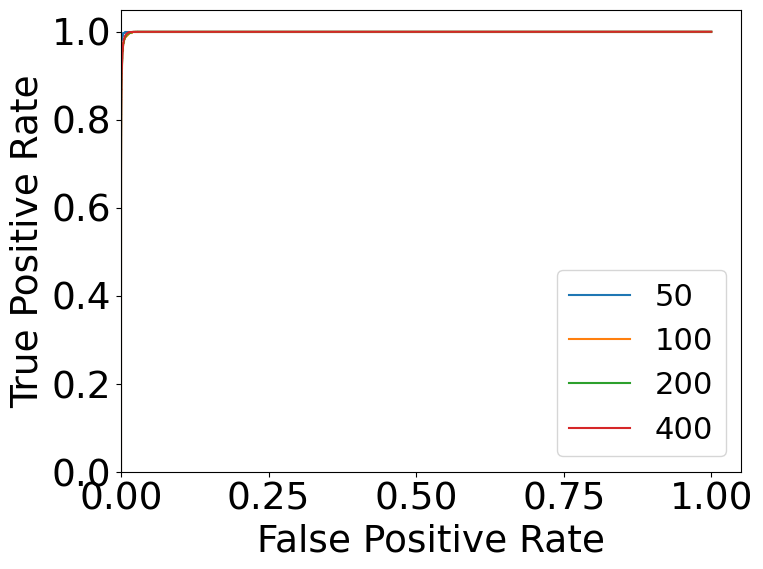

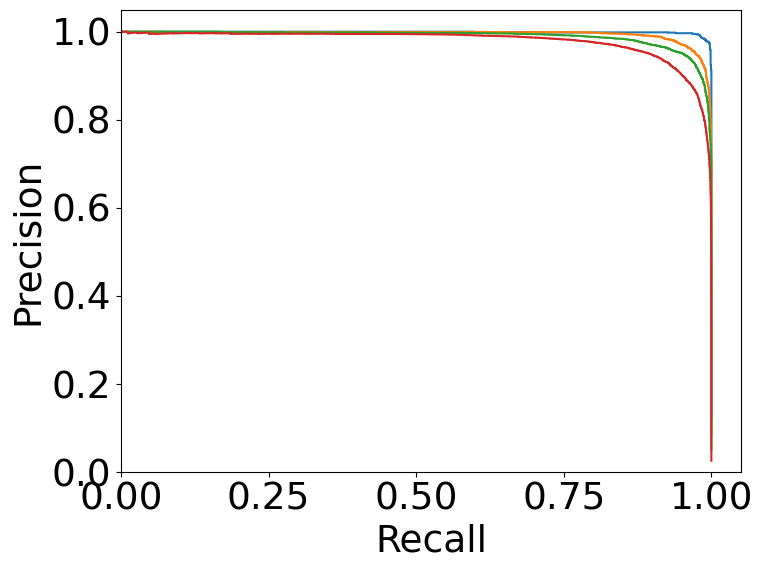

In [15]:
startIn= 3*len(nodes)
endIn= len(nodes)+startIn
evaluate.draw_auc_roc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], nodes)
evaluate.draw_prc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], nodes)

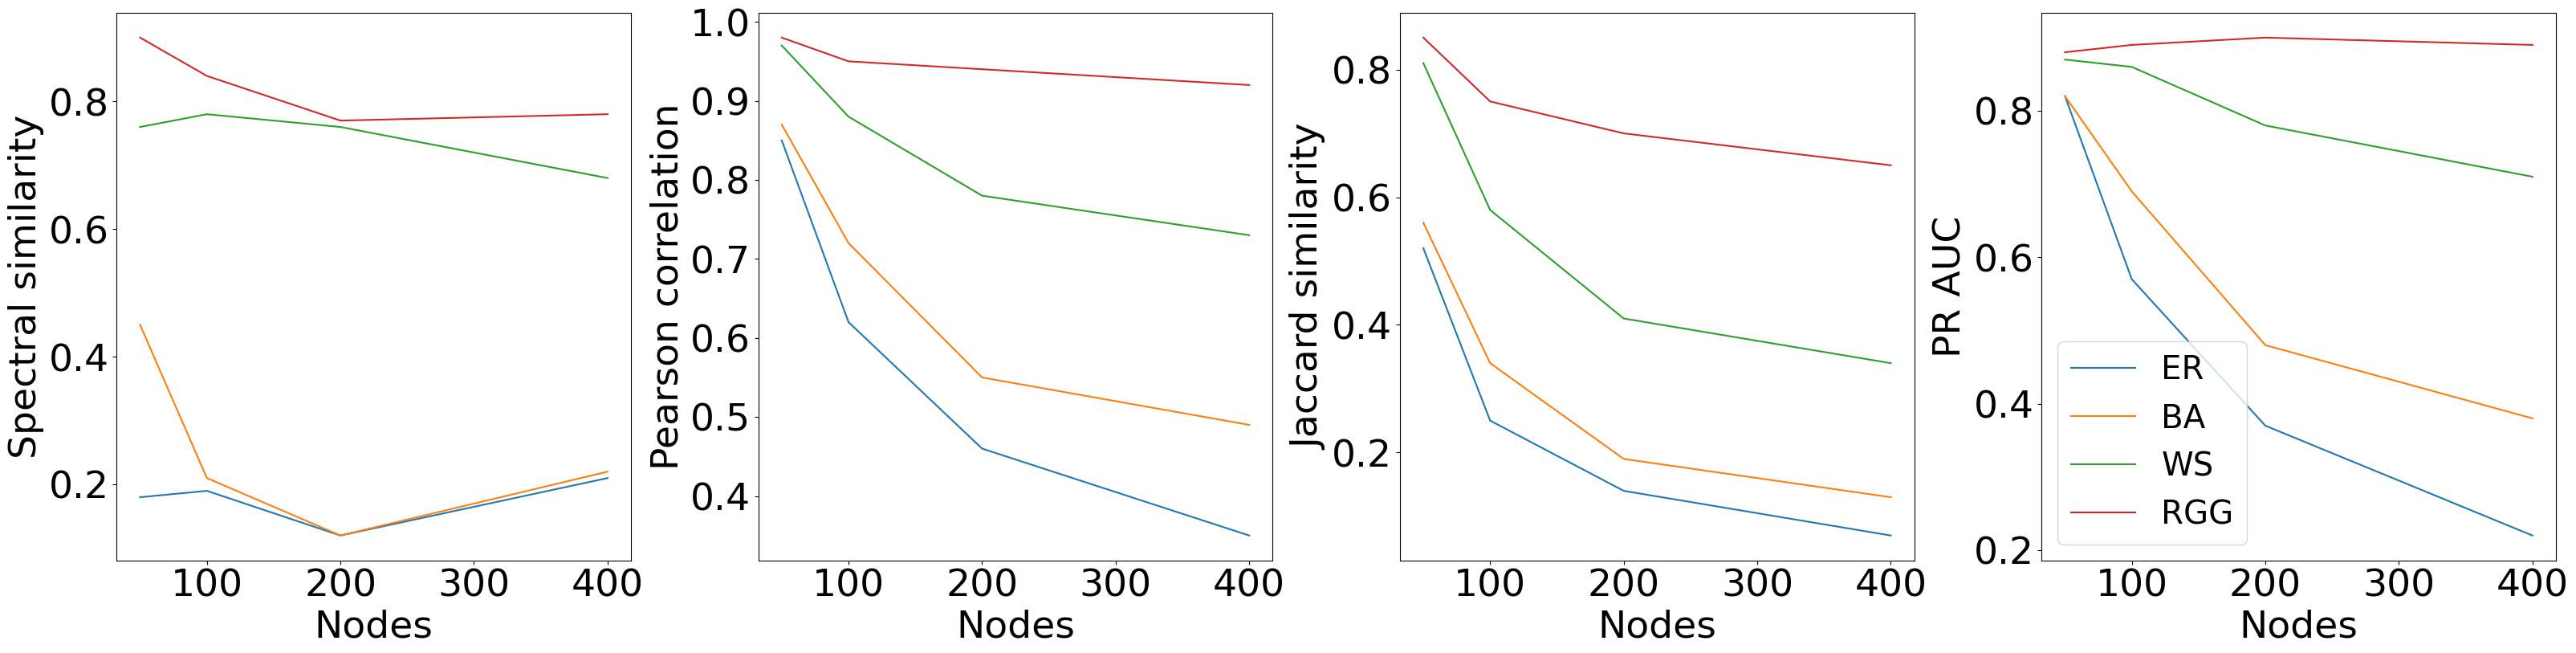

In [37]:
plot_evaluate(nodes, evaluateArray, "Nodes", yLabels, randomGraphs)

In [16]:
#[strain, intense, dense, node, identicalf, epoches]
evaluateMeth= [  evaluate. spectral_similarity, evaluate.pearson_correlation, evaluate.jaccard_similarity, evaluate.PR_AUC]
attriIndex= 1 
attributionL= intenses
auc_rocs_aws, auc_rocs_preA, evaluateLists= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= 1, attributionL= intenses ,seed= 100001, CompareWithRandom= False)
evaluateArray= np.array(evaluateLists)
yLabels= [str(i).split()[1] for i in evaluateMeth]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


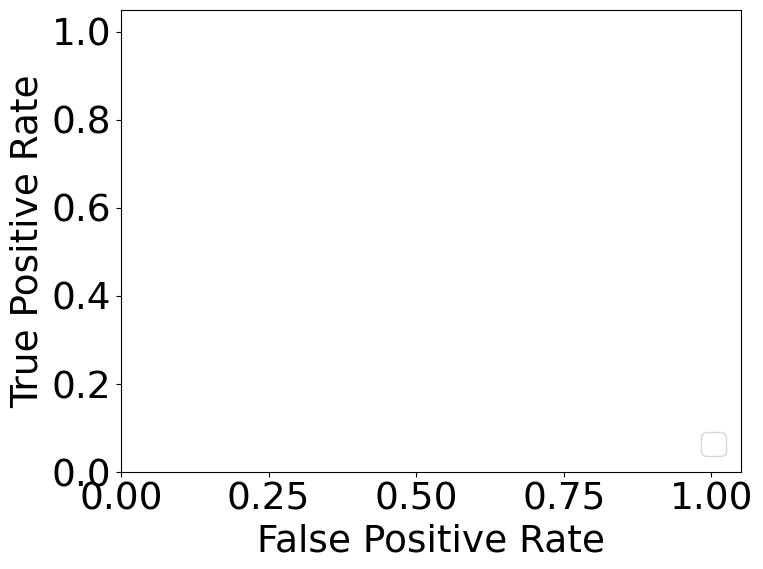

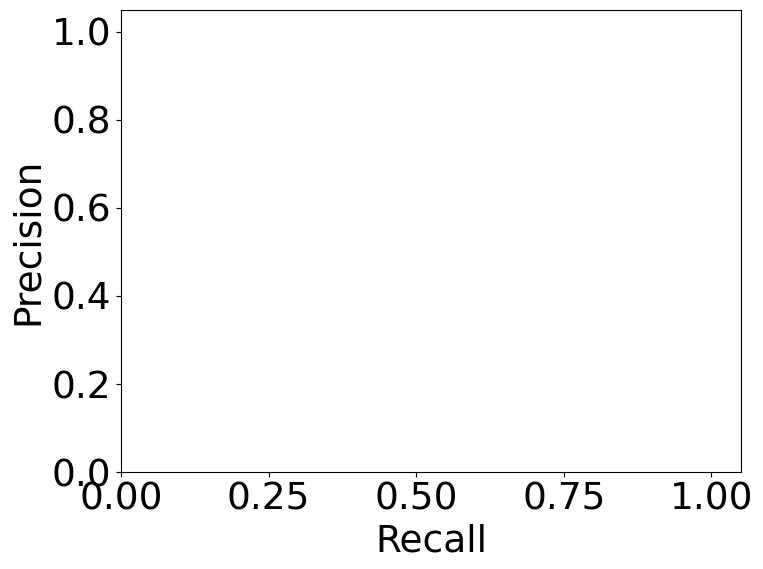

In [17]:
startIn= 1*len(attributionL)
endIn= len(attributionL)+startIn
evaluate.draw_auc_roc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)
evaluate.draw_prc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)

In [18]:
#[strain, intense, dense, node, identicalf, epoches]
evaluateMeth= [  evaluate. spectral_similarity, evaluate.pearson_correlation, evaluate.jaccard_similarity, evaluate.PR_AUC]
auc_rocs_aws, auc_rocs_preA, evaluateLists= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= 4, attributionL= identicalfs, seed= 100001, CompareWithRandom= False, seeds= seeds, randomGraphs= randomGraphs)
evaluateArray= np.array(evaluateLists)
yLabels= [str(i).split()[1] for i in evaluateMeth]

ER 0.6 0.6 -0.2 0.2 0.2 -0.2 -0.2 -0.2 -0.2   0.53 0.57 0.62 0.63 0.63 0.62 0.6 0.57 0.23   0.2 0.23 0.25 0.26 0.26 0.25 0.24 0.22 0.13   0.0 0.0 0.0 0.0 0.0 0.0 0.55 0.52 0.23   
BA 0.2 -0.2 0.2 0.2 -0.2 0.2 -0.2 -0.6 0.19   0.58 0.67 0.68 0.71 0.71 0.72 0.71 0.52 0.24   0.24 0.3 0.32 0.34 0.33 0.34 0.33 0.28 0.14   0.0 0.0 0.0 0.0 0.0 0.0 0.68 0.58 0.24   
WS -0.19 -0.6 0.2 -0.2 0.2 -0.2 -0.59 0.2 0.21   0.8 0.86 0.9 0.9 0.89 0.88 0.87 0.86 0.73   0.48 0.56 0.61 0.62 0.6 0.58 0.57 0.56 0.45   0.0 0.0 0.0 0.0 0.0 0.0 0.86 0.85 0.75   
RGG 0.37 -0.46 -0.03 0.32 0.04 0.58 0.21 -0.59 -0.31   0.87 0.93 0.93 0.95 0.94 0.95 0.95 0.94 0.36   0.63 0.7 0.72 0.75 0.73 0.75 0.74 0.71 0.27   0.0 0.0 0.0 0.0 0.0 0.0 0.89 0.89 0.49   


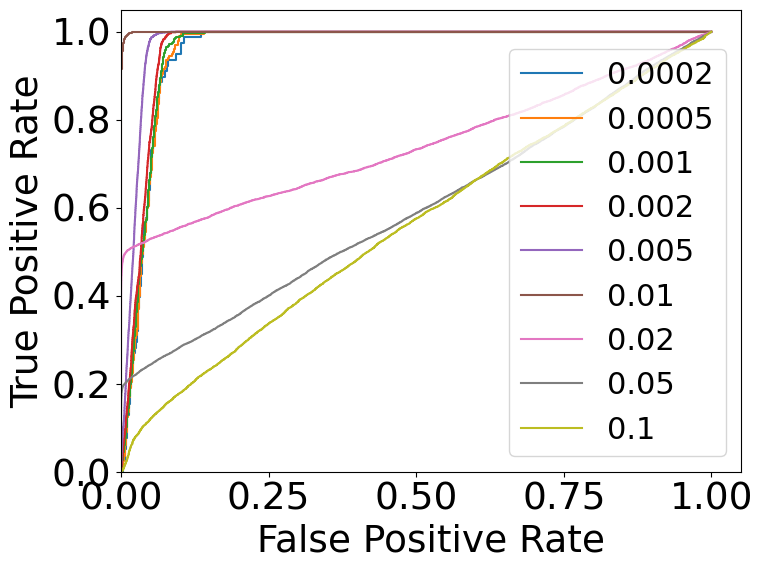

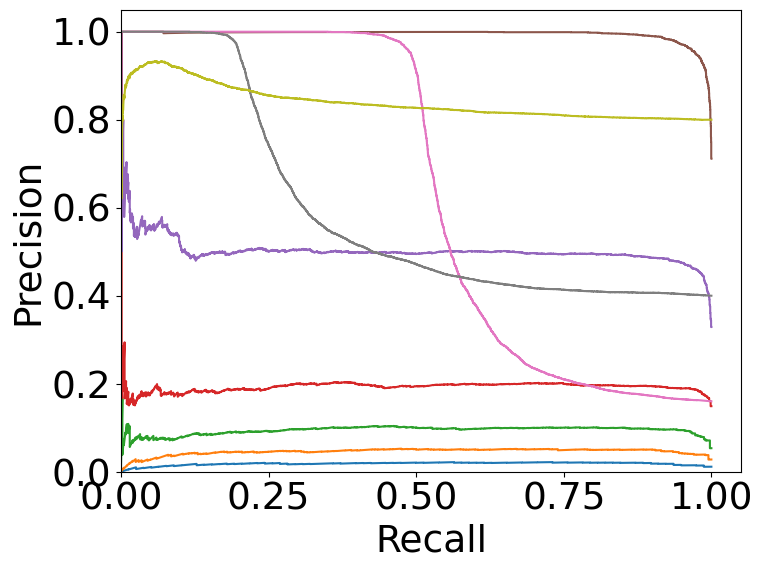

In [34]:
startIn= 3*len(identicalfs)
endIn= len(identicalfs)+startIn
evaluate.draw_auc_roc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], identicalfs)
evaluate.draw_prc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], identicalfs)

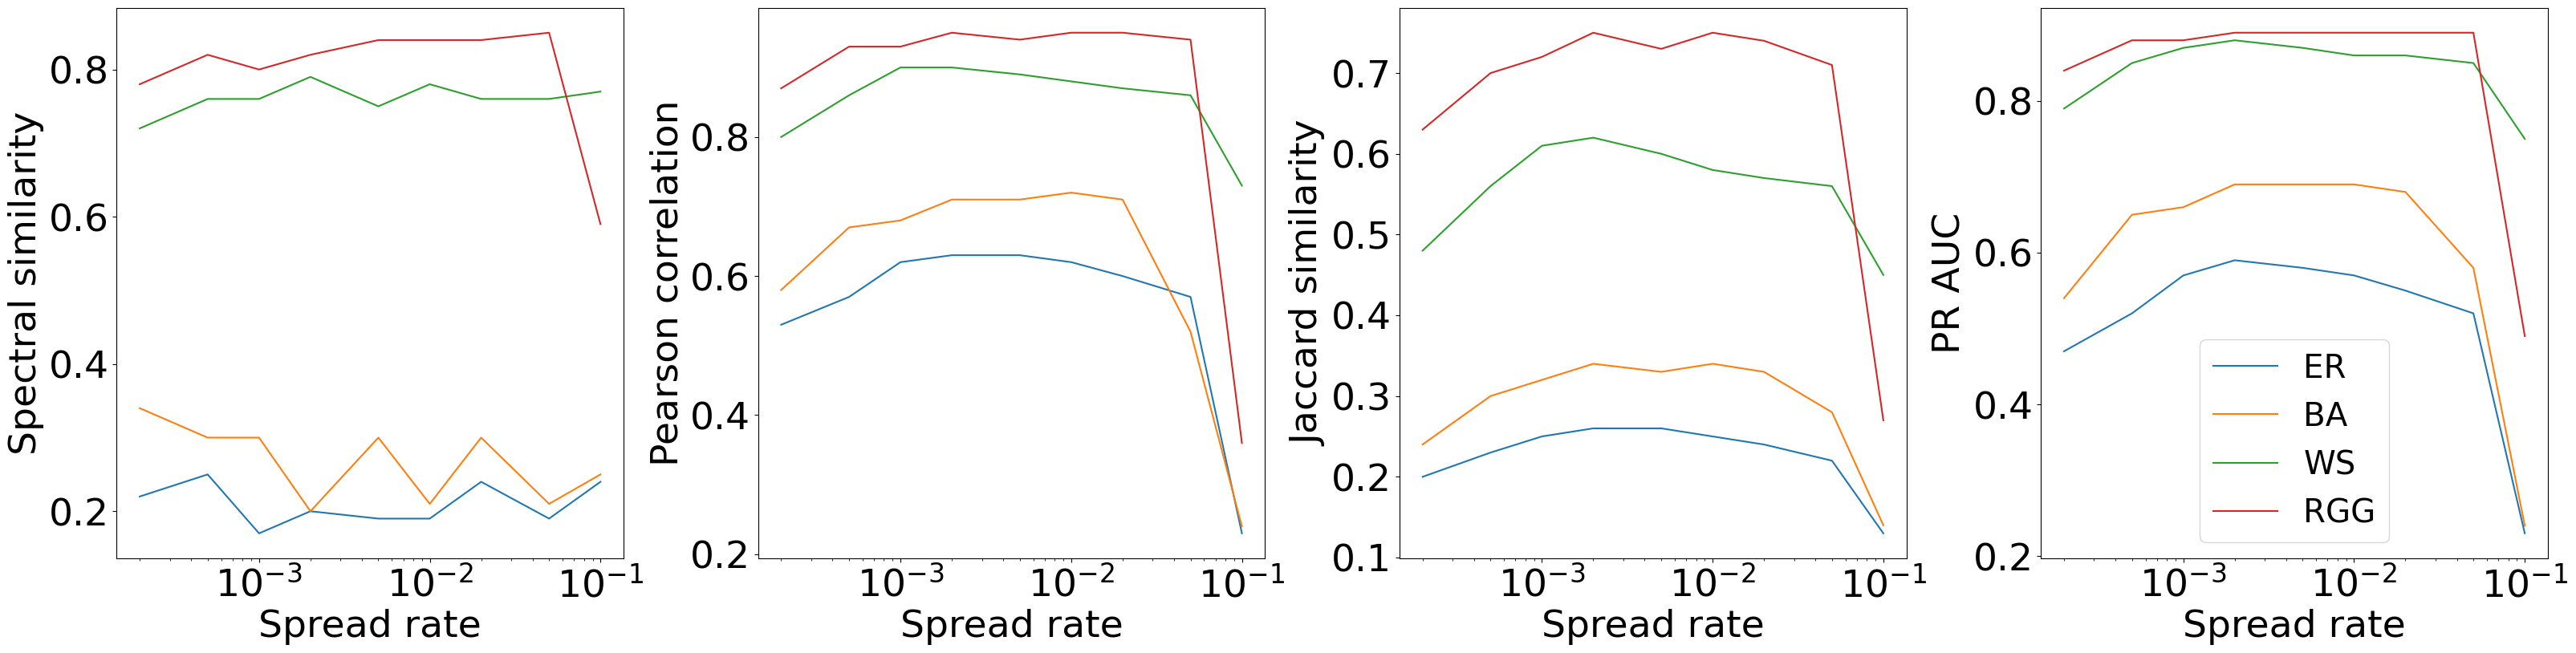

In [35]:
plot_evaluate(identicalfs, evaluateArray, "Spread rate", yLabels, randomGraphs, "log")